# Sentinel-3 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[s3_olci_l2_lfr](https://explorer.digitalearth.africa/products/s3_olci_l2_lfr)

## Background



## Description



***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

In [1]:
%matplotlib inline
import datacube
from deafrica_tools.plotting import display_map

In [2]:
dc = datacube.Datacube(app="Sentinel_3")

In [3]:
dc.list_products().loc[dc.list_products()['description'].str.contains('Sentinel-3')]

,name,description,license,default_crs,default_resolution
name,,,,,
s3_ol_2_wfr_nrt,s3_ol_2_wfr_nrt,Sentinel-3 Level 2 Water Full Resolution (WFR)...,CC-BY-4.0,EPSG:4326,"(-0.003, 0.003)"
s3_olci_l2_lfr,s3_olci_l2_lfr,Sentinel-3 OLCI L2 LAND,CC-BY-4.0,EPSG:4326,"(-0.003, 0.003)"
s3_olci_l2_wfr,s3_olci_l2_wfr,Sentinel-3 OLCI L2 WATER,CC-BY-4.0,EPSG:4326,"(-0.003, 0.003)"
s3_syn_2_vg1,s3_syn_2_vg1,Sentinel-3 Level-2 VG1 SYN product,CC-BY-4.0,EPSG:4326,"(-0.003, 0.003)"


In [4]:
product = "s3_olci_l2_lfr"

### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [5]:
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
GIFAPAR,GIFAPAR,uint16,1,65535,[GI-FAPAR],NaN,0.0,10000.0
IWV_L,IWV_L,uint8,kg/m²,255,[water_vapour],NaN,0.0,1.0
OTCI,OTCI,uint16,1,65535,[chlorophyll],NaN,0.0,10000.0
RC681,RC681,uint16,1,65535,NaN,NaN,0.0,10000.0
RC865,RC865,uint16,1,65535,NaN,NaN,0.0,10000.0
LQSF,LQSF,float32,1,-1,NaN,NaN,0.0,1.0
dataMask,dataMask,uint8,1,255,[mask],NaN,0.0,1.0


In [6]:
latitude = -33.92
longitude = 18.42
buffer = 0.1
time = ('2025-01')

In [7]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

In [8]:
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'time':time,
    'output_crs': 'EPSG:4326',
    'resolution': (0.003, 0.003)}

In [9]:
ds_S3 = dc.load(product=product,
                group_by="solar_day",
                **query)

print(ds_S3)

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 31, latitude: 67, longitude: 68)
Coordinates:
  * time         (time) datetime64[ns] 248B 2025-01-01T03:52:31.500000 ... 20...
  * latitude     (latitude) float64 536B -34.02 -34.02 -34.01 ... -33.82 -33.82
  * longitude    (longitude) float64 544B 18.32 18.32 18.33 ... 18.52 18.52
    spatial_ref  int32 4B 4326
Data variables:
    GIFAPAR      (time, latitude, longitude) uint16 282kB 0 0 0 0 ... 1378 0 0 0
    IWV_L        (time, latitude, longitude) uint8 141kB 41 31 31 31 ... 22 22 0
    OTCI         (time, latitude, longitude) uint16 282kB 0 0 0 ... 18681 0
    RC681        (time, latitude, longitude) uint16 282kB 0 0 0 0 ... 1134 0 0 0
    RC865        (time, latitude, longitude) uint16 282kB 0 0 0 0 ... 2231 0 0 0
    LQSF         (time, latitude, longitude) float32 565kB 1.678e+07 ... 8.0
    dataMask     (time, latitude, longitude) uint8 141kB 0 0 0 0 0 ... 1 1 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  s

In [11]:
ds_S3['GIFAPAR'] = ds_S3.GIFAPAR / 10000

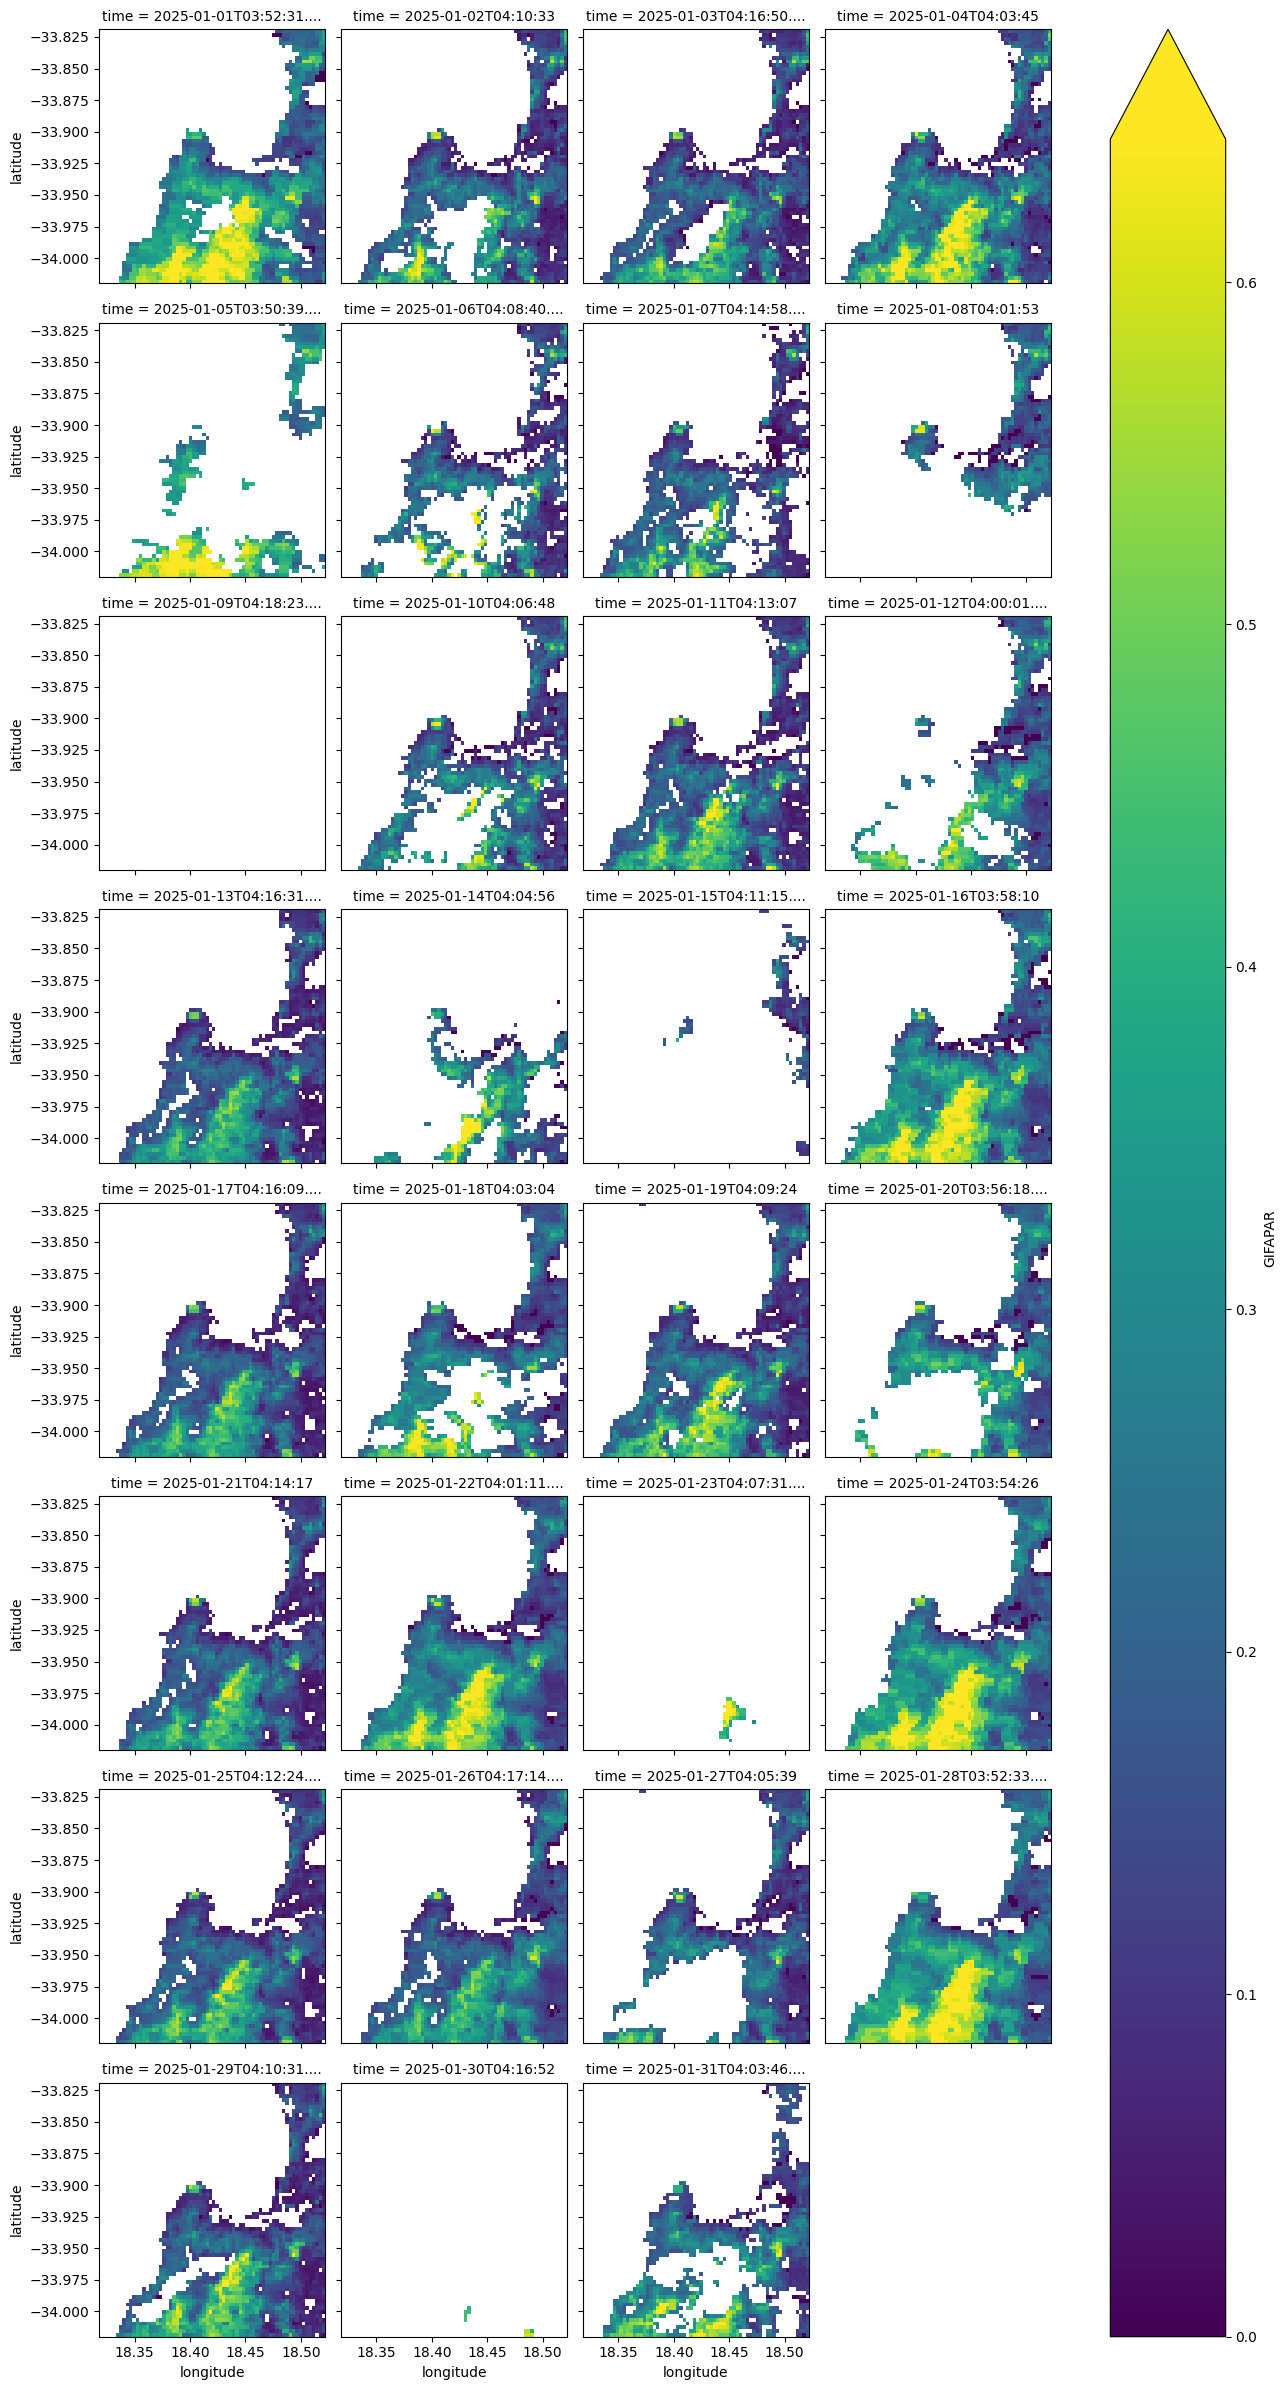

In [12]:
ds_S3.GIFAPAR.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);

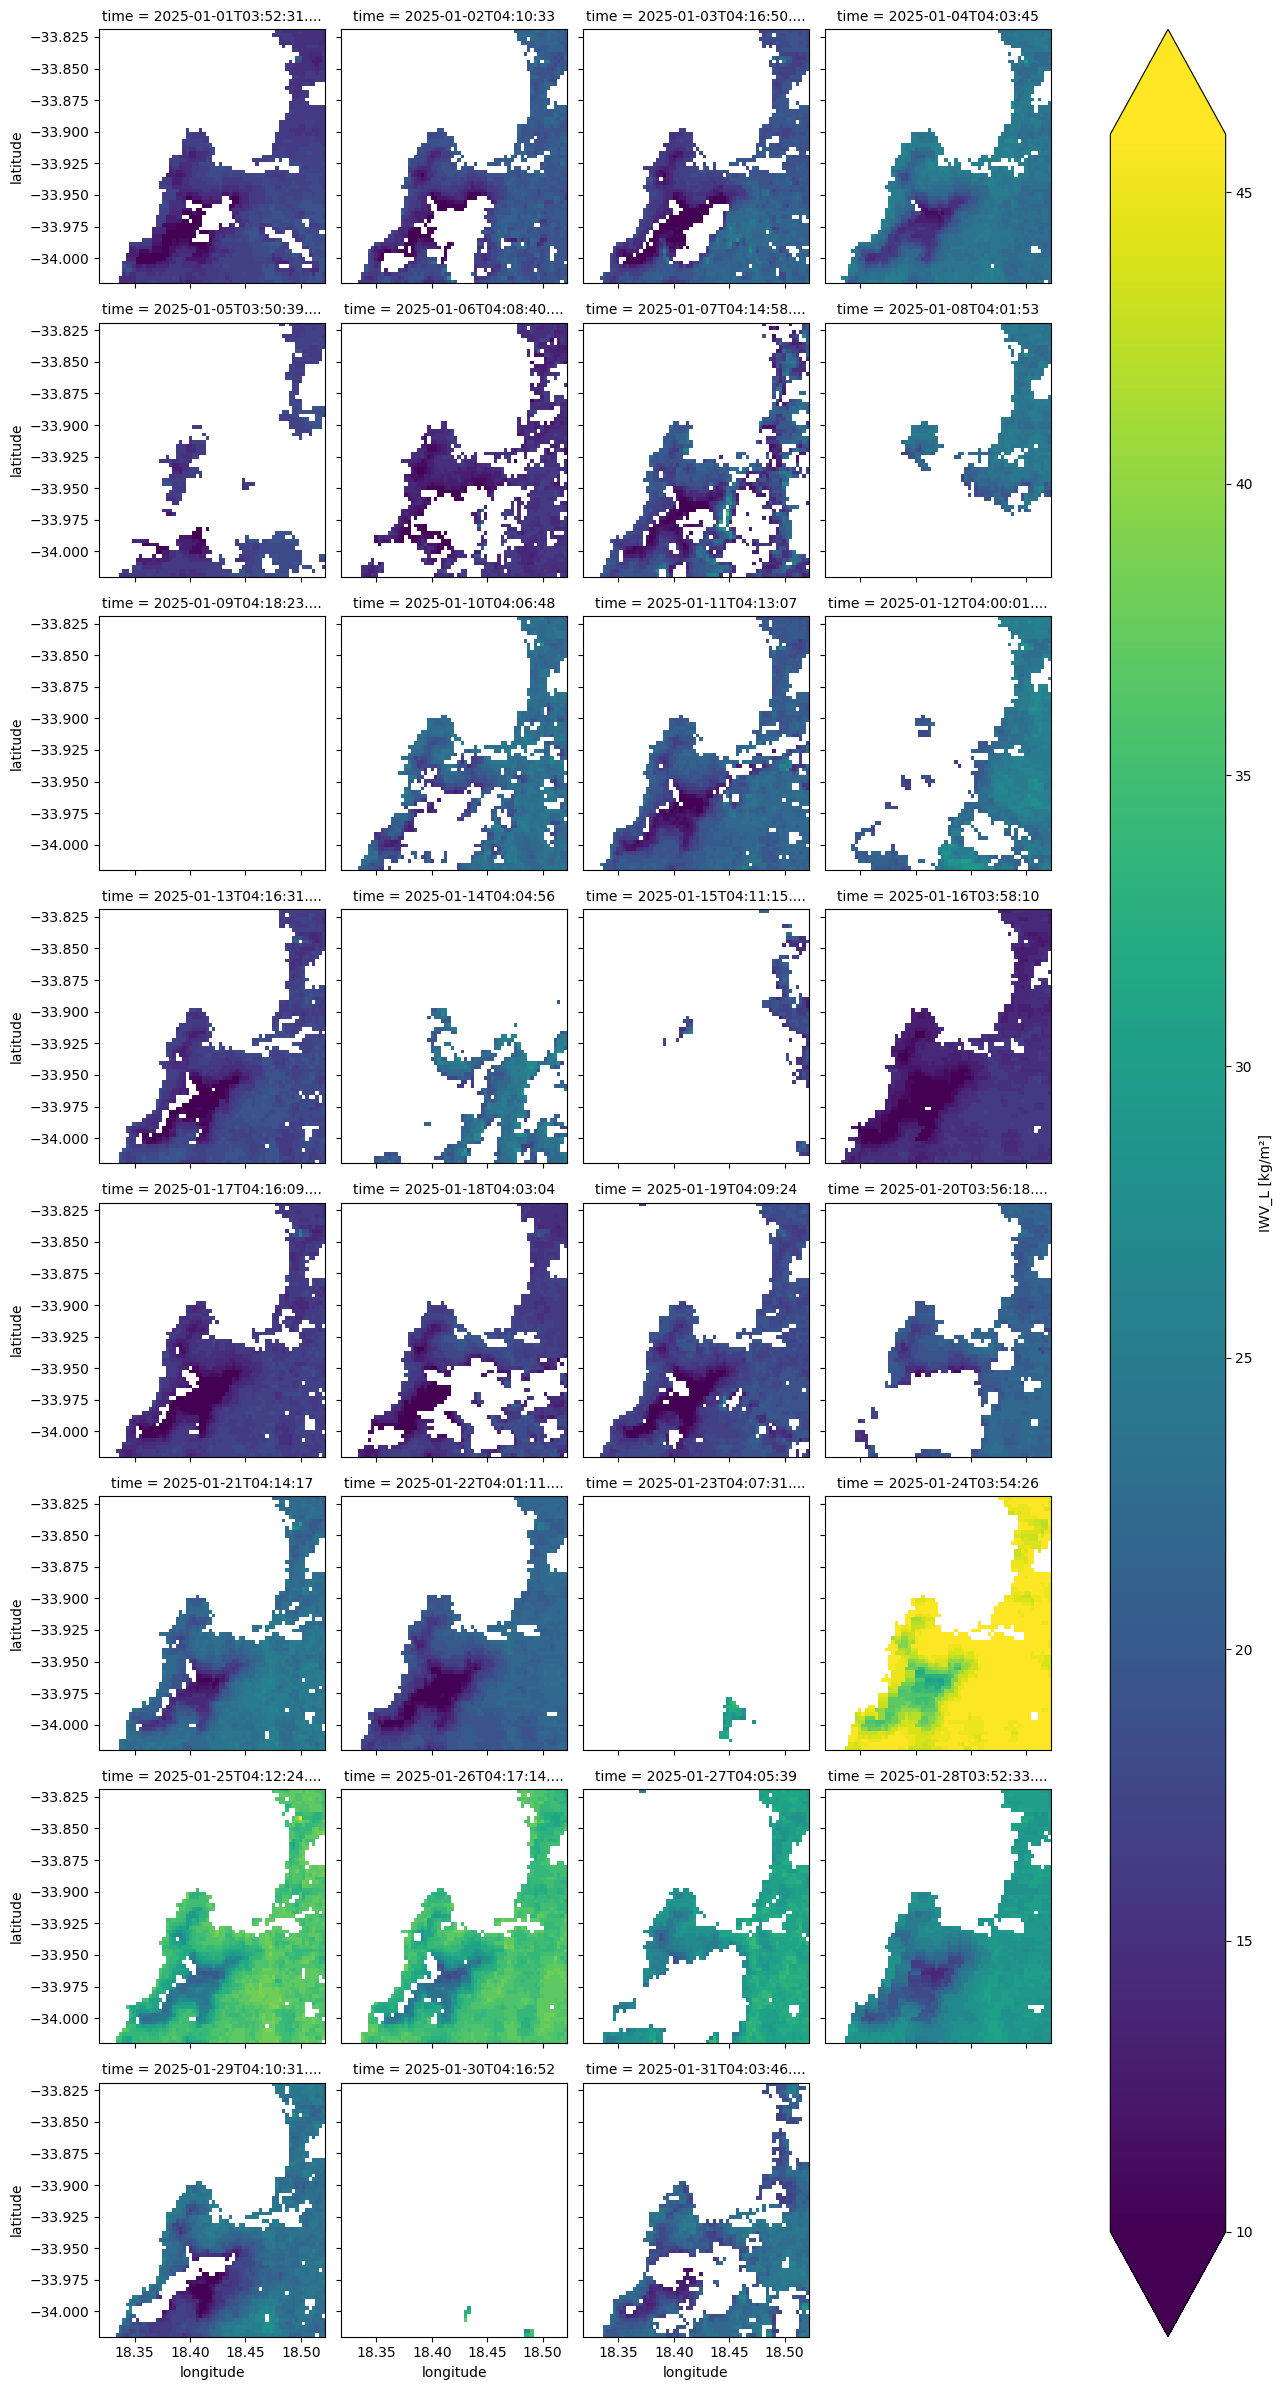

In [13]:
ds_S3.IWV_L.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);

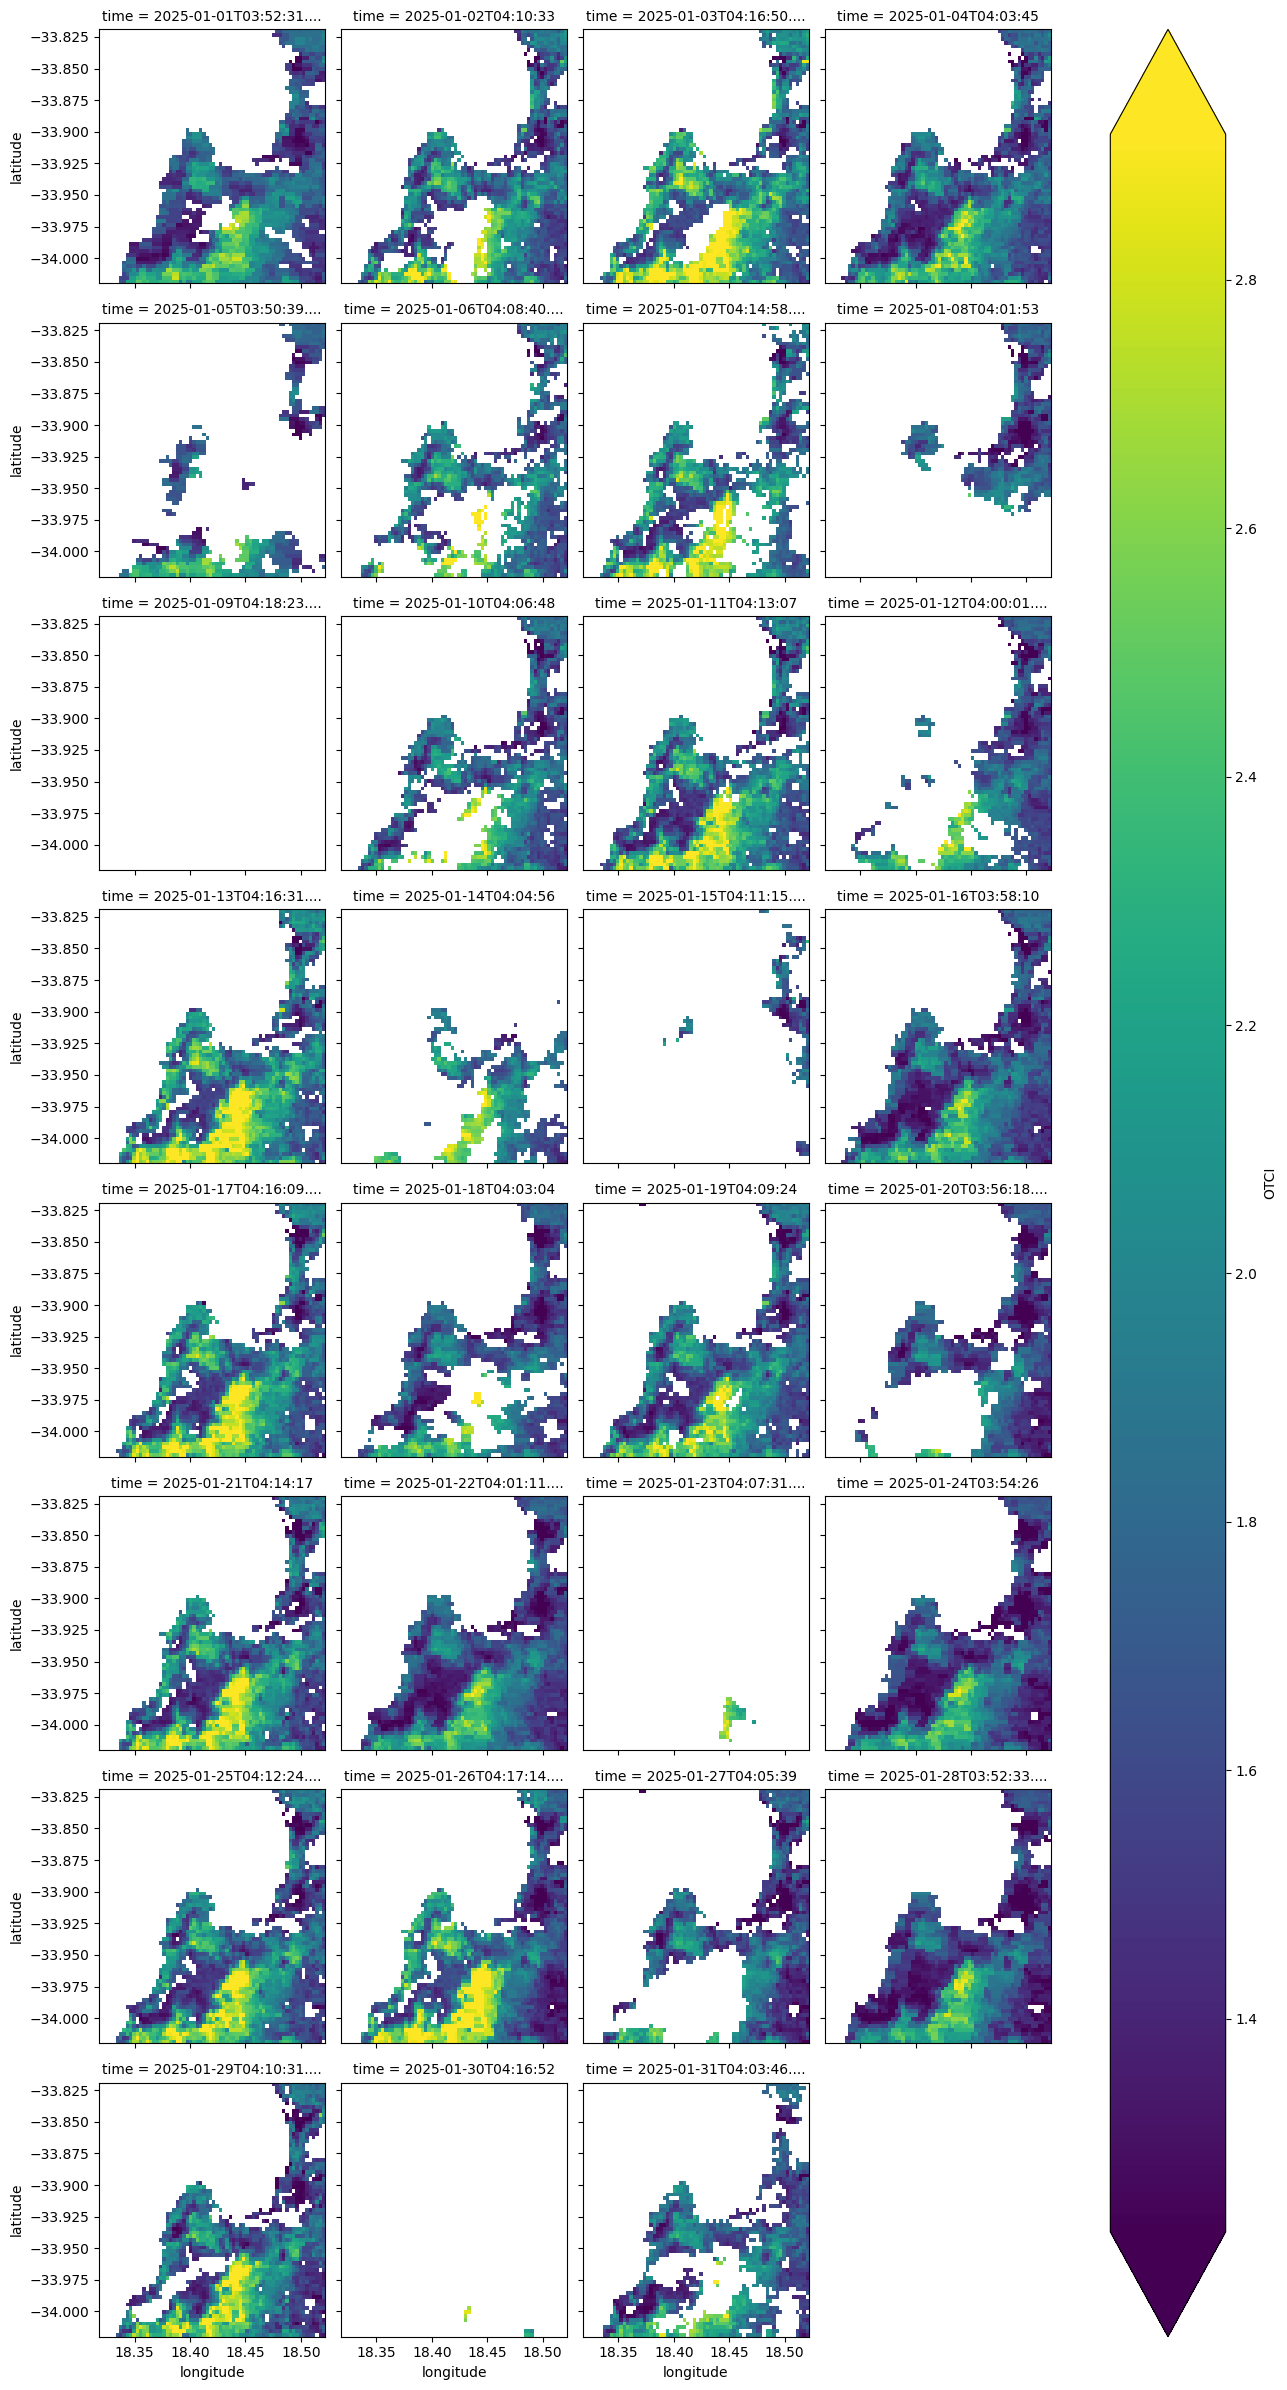

In [14]:
ds_S3['OTCI'] = ds_S3.OTCI / 10000

ds_S3.OTCI.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);

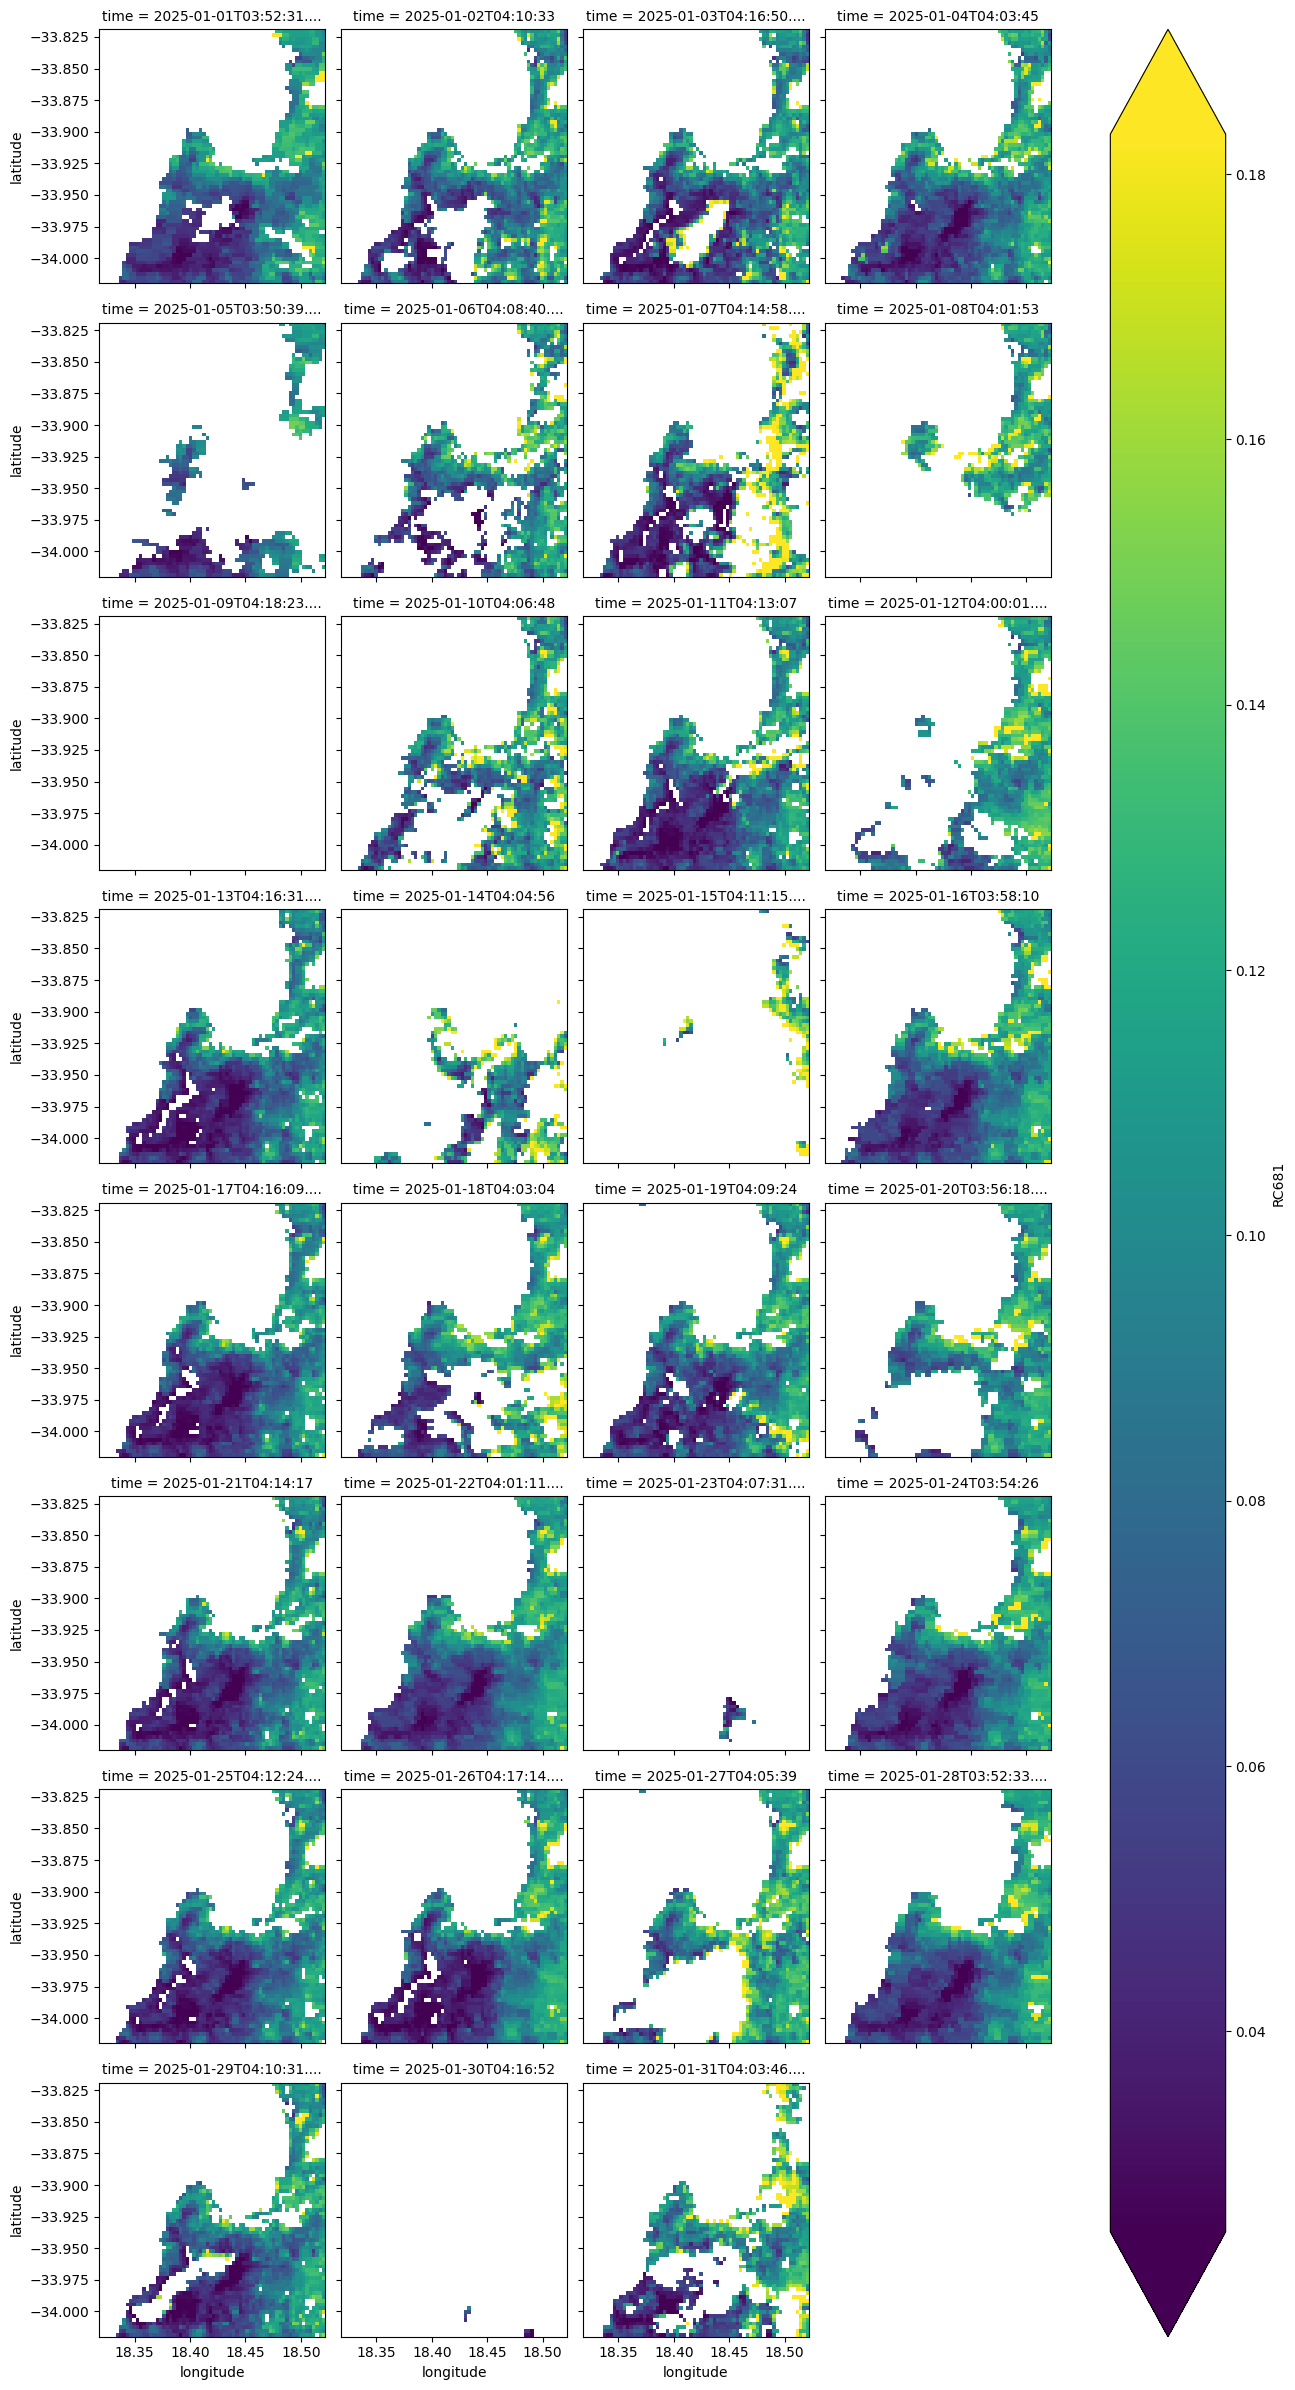

In [15]:
ds_S3['RC681'] = ds_S3.RC681 / 10000

ds_S3.RC681.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);

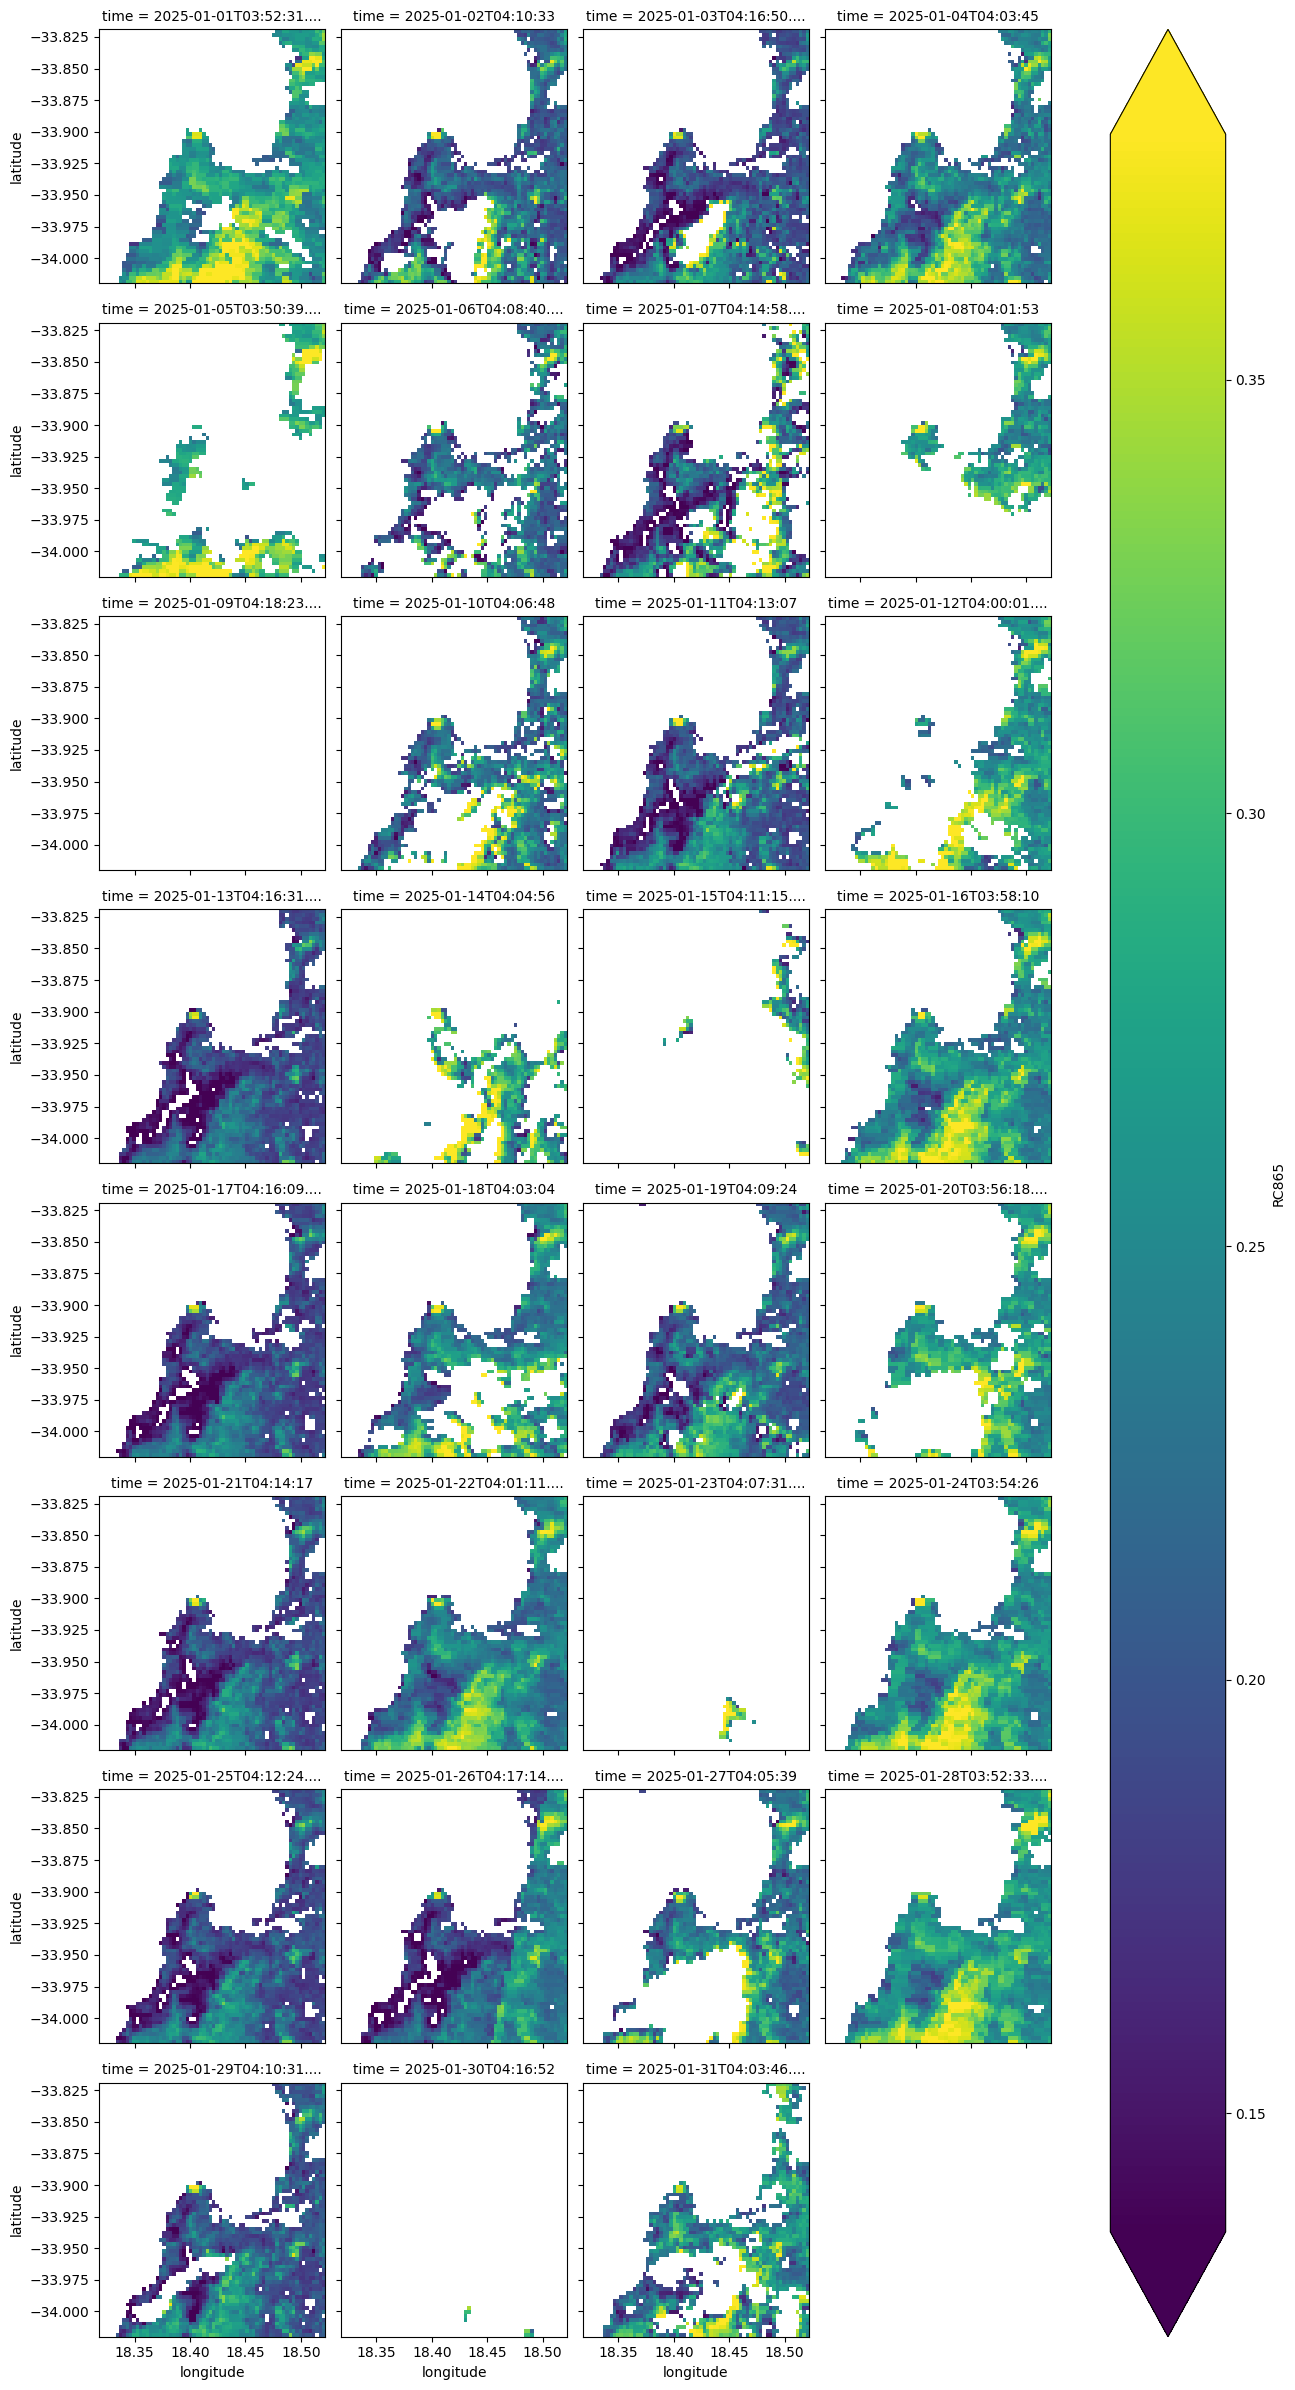

In [16]:
ds_S3['RC865'] = ds_S3.RC865 / 10000

ds_S3.RC865.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);